### Using pre-trained model

Today we're going to build and fine-tune CNN based on weights pre-trained on ImageNet: the largest image classification dataset as of now.
More about imagenet: http://image-net.org/
Setup: classify from a set of 1000 classes.

In [2]:
import requests

# class labels
LABELS_URL = 'https://gist.githubusercontent.com/ShamsUlAzeem/3ea5740b960d854f4bd43e7322b858e3/raw/e8e3d428fb94af3c1c20beea9183de364ecbc3a5/imagenet-labels.json'
labels = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}

In [3]:
print(list(labels.items())[:5])

[(0, 'tench, Tinca tinca'), (1, 'goldfish, Carassius auratus'), (2, 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'), (3, 'tiger shark, Galeocerdo cuvieri'), (4, 'hammerhead, hammerhead shark')]


### TorchVision
PyTorch has several companion libraries, one of them being [torchvision](https://github.com/pytorch/vision/tree/master/) - it contains a number of popular vision datasets, preprocessing tools and most importantly, [pre-trained models](https://github.com/pytorch/vision/tree/master/torchvision/models).

For now, we're going to use torch Inception-v3 module.

We're gonna use the inception-v3 network:
![img](https://hackathonprojects.files.wordpress.com/2016/09/googlenet_diagram.png?w=650&h=192)

Let's first look at the code here: [url](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py)

In [245]:
from torchvision.models.inception import inception_v3

model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model.train(False)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [5]:
import torch

dummy_x = torch.randn(5, 3, 299, 299)
model(dummy_x)

tensor([[-0.9785,  0.8827,  1.6164,  ..., -2.1453, -0.4571,  1.8375],
        [-1.2131,  0.9565,  1.8116,  ..., -2.1391, -0.3041,  1.7042],
        [-0.9302,  1.2236,  2.1813,  ..., -2.1849, -0.4135,  1.5028],
        [-1.1926,  0.6840,  1.6898,  ..., -2.0832, -0.4022,  1.5737],
        [-1.1912,  0.6694,  1.2705,  ..., -2.1774, -0.5547,  1.6538]],
       grad_fn=<AddmmBackward0>)

### Predict class probabilities

In [6]:
# If using Colab
!mkdir sample_images
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg -O sample_images/albatross.jpg

--2021-12-26 13:47:03--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11607 (11K) [image/jpeg]
Saving to: ‘sample_images/albatross.jpg’

sample_images/albat 100%[===================>]  11.33K  --.-KB/s    in 0s      

2021-12-26 13:47:03 (53.4 MB/s) - ‘sample_images/albatross.jpg’ saved [11607/11607]



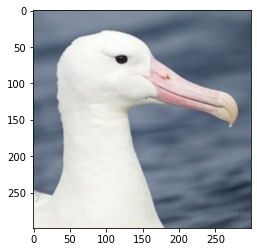

top-10 classes are: 
 [prob : class label]
0.9745 :	albatross
0.0030 :	turnstile
0.0005 :	Shetland sheepdog
0.0005 :	llama
0.0003 :	collie
0.0003 :	drake
0.0003 :	hammerhead
0.0003 :	nipple
0.0003 :	Polaroid camera


In [292]:
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline

img = resize(plt.imread('sample_images/albatross.jpg'), (299, 299))
plt.imshow(img)
plt.show()


def transform_input(img):
    return torch.as_tensor(img.reshape([1, 299, 299, 3]).transpose([0, 3, 1, 2]), dtype=torch.float32)


def predict(img):
    img = transform_input(img)
    
    probs = torch.nn.functional.softmax(model(img), dim=-1)
    
    probs = probs.data.numpy()
    
    top_ix = probs.ravel().argsort()[-1:-10:-1]
    print ('top-10 classes are: \n [prob : class label]')
    for l in top_ix:
        print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))
        

predict(img)

### Having fun with pre-trained nets

In [12]:
!wget https://www.nv-lab.ru/images/upload/editor8047.jpg -O img.jpg

--2021-12-26 13:49:45--  https://www.nv-lab.ru/images/upload/editor8047.jpg
Resolving www.nv-lab.ru (www.nv-lab.ru)... 195.42.163.198
Connecting to www.nv-lab.ru (www.nv-lab.ru)|195.42.163.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25181 (25K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  24.59K  --.-KB/s    in 0.001s  

2021-12-26 13:49:46 (44.1 MB/s) - ‘img.jpg’ saved [25181/25181]



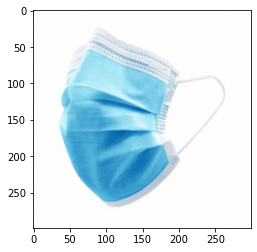

top-10 classes are: 
 [prob : class label]
0.7908 :	shower cap
0.0713 :	diaper
0.0152 :	bathing cap
0.0074 :	bonnet
0.0057 :	knee pad
0.0056 :	bib
0.0053 :	jellyfish
0.0042 :	brassiere
0.0039 :	pick


In [13]:
img = resize(plt.imread('img.jpg'), (299, 299))
plt.imshow(img)
plt.show()

predict(img)

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [9]:
!wget -nc https://www.dropbox.com/s/ae1lq6dsfanse76/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip -n data.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

### How to get features
During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

In [16]:
from copy import deepcopy  # in case you still need original model

embedding = deepcopy(model)

class Identity(torch.nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
        
    
# redefine the last layer to be Identity
embedding.fc = Identity()

assert embedding(transform_input(img)).data.numpy().shape == (1, 2048), "your output for single image should have shape (1, 2048)"

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [230]:
#extract features from images
from tqdm import tqdm
from imageio import imread
import PIL.Image as Image
import os
import numpy as np

X = []
Y = []

batch_size = 32
imgs = np.zeros([batch_size, 299, 299, 3])
batch_index = 0

for fname in tqdm(os.listdir('train')):
    
    y = fname.startswith("cat")
    Y.append(y)
    
    img = imread(os.path.join("train", fname))
    
    img = np.array(Image.fromarray(img).resize((299, 299))) / 255.
    imgs[batch_index] = img
    
    if batch_index == batch_size - 1:
        input_tensor = torch.as_tensor(imgs.transpose([0,3,1,2]), dtype=torch.float32)

        with torch.no_grad():
          # use your embedding model to produce feature vector
            features = embedding(input_tensor).data.numpy()
        
        X.append(features)
        
        batch_index = 0
        continue
        
    batch_index += 1

100%|██████████| 25000/25000 [2:06:53<00:00,  3.28it/s]


In [231]:
X = np.concatenate(X) #stack all [1xfeatures] matrices into one. 
assert X.ndim == 2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = np.array(Y[:len(X)])

print(X.shape, Y.shape)

(24992, 2048) (24992,)


In [1]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [232]:
sss = StratifiedShuffleSplit(n_splits = 2, test_size = 0.15, random_state = 30)
for train_val_idx, test_idx in sss.split(X, Y):
  X_train_val = X[train_val_idx]
  X_test = X[test_idx]
  y_train_val = Y[train_val_idx]
  y_test = Y[test_idx]

sss = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 30)
for train_idx, val_idx in sss.split(X_train_val, y_train_val):
  X_train = X[train_idx]
  X_val = X[val_idx]
  y_train = Y[train_idx]
  y_val = Y[val_idx]

In [233]:
print('Train: ' + str(X_train.shape))
print('Val: ' + str(X_val.shape))
print('Test: X - ' + str(X_test.shape) + ' Y - ' + str(y_test.shape))

Train: (16994, 2048)
Val: (4249, 2048)
Test: X - (3749, 2048) Y - (3749,)


In [238]:
cross_val_score(LogisticRegression(max_iter=300), X_train_val, y_train_val, cv=3)

array([0.98870216, 0.98517159, 0.98912583])

In [240]:
log_reg_model = LogisticRegression(max_iter = 1000).fit(X_train, y_train)

In [241]:
accuracy_score(y_test, log_reg_model.predict(X_test))

0.9943985062683383

# Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by sending the correct parameters in the optimizer
      * `opt = torch.optim.Adam([head_only.parameters()])``
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate

# Bonus: #deepdream

https://twitter.com/search?q=%23deepdream&src=typd

Code is heavily based on https://github.com/thesemicolonguy/deep-dream-pytorch

Original blogpost where more ideas can be taken from: https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

In [242]:
from PIL import Image, ImageFilter, ImageChops
from torchvision import transforms
import numpy as np

In [243]:
modulelist = list(model.children())

In [277]:
preprocess = transforms.Compose([
   transforms.Resize((299, 299)),  # do we really need this now?
    transforms.ToTensor()#,
    ])


def dd_helper(image, layer, iterations, lr):
    input_var = torch.as_tensor(preprocess(image).unsqueeze(0), dtype=torch.float32)
    input_var.requires_grad_()
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data
    
    input_im = input_var.data.squeeze()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [278]:
def deep_dream(image, layer, iterations, lr, octave_scale, num_octaves):
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if (image1.size[0] / octave_scale < 1 or image1.size[1] / octave_scale < 1):
            size = image1.size
        else:
            size = (int(image1.size[0] / octave_scale), int(image1.size[1] / octave_scale))
            
        image1 = image1.resize(size, Image.ANTIALIAS)
        image1 = deep_dream(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size, Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
    print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

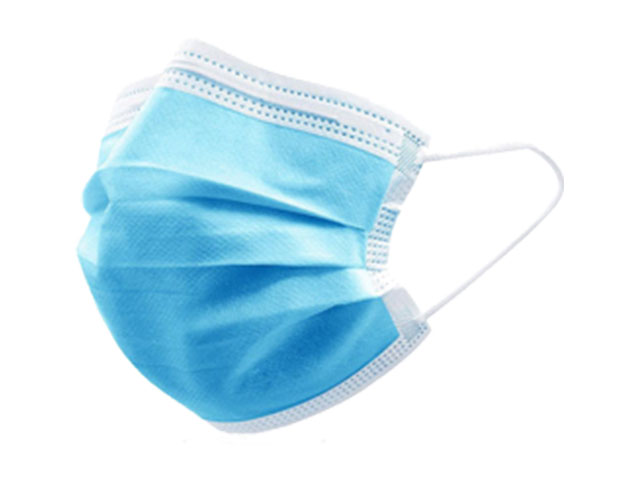

In [279]:
img = Image.fromarray(plt.imread('img.jpg'))
img

-------------- Recursive level:  0 --------------
-------------- Recursive level:  1 --------------
-------------- Recursive level:  2 --------------
-------------- Recursive level:  3 --------------
-------------- Recursive level:  4 --------------
-------------- Recursive level:  5 --------------
-------------- Recursive level:  6 --------------
-------------- Recursive level:  7 --------------
-------------- Recursive level:  8 --------------
-------------- Recursive level:  9 --------------
-------------- Recursive level:  10 --------------
-------------- Recursive level:  11 --------------
-------------- Recursive level:  12 --------------
-------------- Recursive level:  13 --------------
-------------- Recursive level:  14 --------------
-------------- Recursive level:  15 --------------
-------------- Recursive level:  16 --------------
-------------- Recursive level:  17 --------------
-------------- Recursive level:  18 --------------
-------------- Recursive level:  19 -----

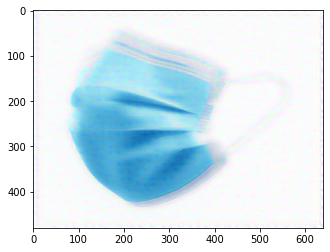

In [280]:
output = deep_dream(img, 5, 5, 0.3, 2, 20)

-------------- Recursive level:  0 --------------
-------------- Recursive level:  1 --------------


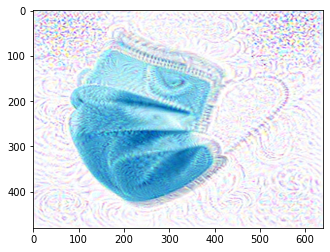

In [281]:
output = deep_dream(img, 12, 5, 0.2, 2, 1)

In [ ]:
#can you implement one class probability optimization to make model dream about bananas
<YOUR CODE>

# Bonus 2: Adversarial Attack

Original PyTorch tutorial is [here](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)

In [314]:
!wget https://blog.acolyer.org/wp-content/uploads/2017/02/explaining-adversarial-panda.jpeg -O img2.jpg

--2021-12-26 19:31:12--  https://blog.acolyer.org/wp-content/uploads/2017/02/explaining-adversarial-panda.jpeg
Resolving blog.acolyer.org (blog.acolyer.org)... 65.8.181.82, 65.8.181.40, 65.8.181.84, ...
Connecting to blog.acolyer.org (blog.acolyer.org)|65.8.181.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82848 (81K) [image/jpeg]
Saving to: ‘img2.jpg’

img2.jpg            100%[===================>]  80.91K  --.-KB/s    in 0.03s   

2021-12-26 19:31:12 (3.11 MB/s) - ‘img2.jpg’ saved [82848/82848]



In [396]:
# Change the Deep Dream step function
# to make it doing adversarial example from original image


def dd_helper_modified(image, layer, iterations, lr, magnitude):
    input_var = torch.as_tensor(preprocess(image).unsqueeze(0), dtype=torch.float32)
    input_var.requires_grad_()
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):  # maybe change this
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + magnitude * np.sign(lr * input_var.grad.data) # and probably this
    input_im = input_var.data.squeeze()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

top-10 classes are: 
 [prob : class label]
0.7527 :	giant panda
0.0298 :	soccer ball
0.0051 :	indri
0.0048 :	kuvasz
0.0040 :	lesser panda
0.0036 :	nipple
0.0033 :	Samoyed
0.0024 :	Great Pyrenees
0.0024 :	Japanese spaniel


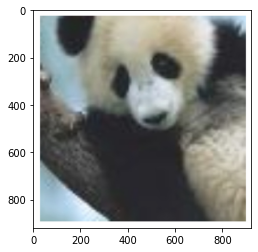

In [393]:
predict(resize(np.asarray(img2), (299, 299)))
plt.imshow(img2)

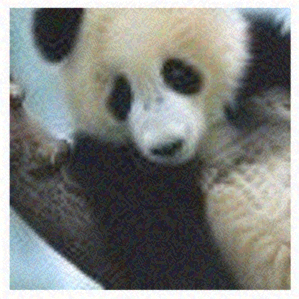

In [404]:
img2 = Image.fromarray(plt.imread('img2.jpg'))
img_adv = dd_helper_modified(img2, 10, 1, 1, 0.03)
img_adv

In [405]:
predict(resize(np.asarray(img_adv), (299, 299)))

top-10 classes are: 
 [prob : class label]
0.1202 :	Pomeranian
0.1099 :	giant panda
0.0594 :	Samoyed
0.0573 :	squirrel monkey
0.0384 :	titi
0.0249 :	gibbon
0.0193 :	capuchin
0.0155 :	Arctic fox
0.0145 :	Great Pyrenees
